In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Add N/C ratio

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]
nc_ratio = []

height = 128
width = 128
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

def parse_dat_file(dat_path):
    points = []
    with open(dat_path, 'rb') as file:
        raw_data = file.read()
        decoded_data = raw_data.decode('utf-8', errors='ignore')
        lines = decoded_data.strip().split('\n')
        for line in lines:
            if ',' in line:
                try:
                    x_str, y_str = line.strip().split(',')
                    x, y = float(x_str), float(y_str)
                    points.append((x, y))
                except ValueError:
                    continue

    return points

    # if len(points) < 3:
    # raise ValueError("At least 3 points are required to form a polygon")

    # segmentation = [coord for point in points for coord in point]

# print(Class)
i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            file_path_cyt = f"{p}{a[:-4]}_cyt.dat"
            file_path_nuc = f"{p}{a[:-4]}_nuc.dat"
            points_nuc = parse_dat_file(file_path_nuc)
            points_cyt = parse_dat_file(file_path_cyt)
            # print(points_cyt)
            coords_cyt = np.array(points_cyt)
            x_cyt = coords_cyt[:, 0]
            y_cyt = coords_cyt[:, 1]
            area_cyt = 0.5 * np.abs(np.dot(x_cyt, np.roll(y_cyt, -1)) - np.dot(y_cyt, np.roll(x_cyt, -1)))
            coords_nuc = np.array(points_nuc)
            x_nuc = coords_nuc[:, 0]
            y_nuc = coords_nuc[:, 1]
            area_nuc = 0.5 * np.abs(np.dot(x_nuc, np.roll(y_nuc, -1)) - np.dot(y_nuc, np.roll(x_nuc, -1)))
            # print(area_nuc/area_cyt)
            nc_ratio.append(area_nuc/area_cyt)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
nc_ratio = np.array(nc_ratio)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]
nc_ratio = nc_ratio[s]

(4049, 128, 128, 3)
(4049,)
[0 0 0 ... 4 4 4]


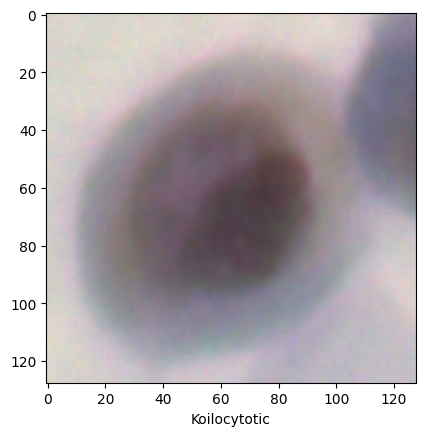

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=128)
features_densenet     = model_densenet.predict(data, batch_size=128)
features_efficientnet = model_densenet.predict(data, batch_size=128)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
(4049, 4, 4, 2048)
(4049, 4, 4, 1024)
(4049, 4, 4, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label, nc_ratio in zip(features_resnet, features_densenet, features_efficientnet, labels, nc_ratio):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    f_r = np.append(f_r, nc_ratio)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 65538)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-2]
y = extracted_features[:, -2]
nc = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 1)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)
principal_X_with_nc = np.concatenate((principal_X, nc.reshape(-1, 1), ), axis=1)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1
[0.15979608]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(
    principal_X_with_nc, y, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2834, 2)
(1215, 2)
(2834,)
(1215,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.02))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,053 (8.02 KB)

 Trainable params: 2,053 (8.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 200
nn = model.fit(X_train, y_train, batch_size=128, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2925 - loss: 1.5706
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3673 - loss: 1.3772
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3858 - loss: 1.3520
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4049 - loss: 1.3262
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4018 - loss: 1.3028 
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4066 - loss: 1.2927
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4264 - loss: 1.2805
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4383 - loss: 1.2625
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4446 - loss: 1.2497 
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4630 - loss: 1.2265
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4779 - loss: 1.1999
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accurac

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  65.59670781893004


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.69      0.79      0.73       242
         1.0       0.59      0.45      0.51       258
         2.0       0.50      0.62      0.55       205
         3.0       0.58      0.52      0.55       255
         4.0       0.90      0.91      0.90       255

    accuracy                           0.66      1215
   macro avg       0.65      0.66      0.65      1215
weighted avg       0.66      0.66      0.65      1215



[[190  47   1   2   2]
 [ 65 116  19  55   3]
 [  0  17 127  40  21]
 [ 20  17  85 132   1]
 [  1   0  22   0 232]]


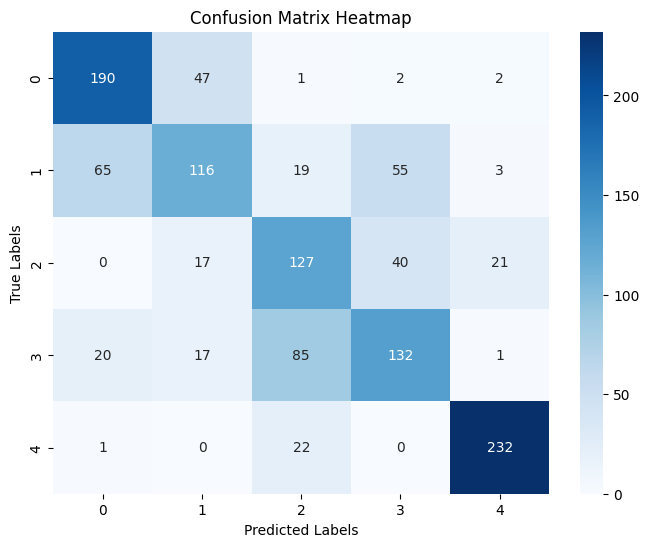

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Old Version

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]

height = 128
width = 128
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)

            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
# nc_ratio = np.array(nc_ratio)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(4049, 128, 128, 3)
(4049,)
[0 0 0 ... 4 4 4]


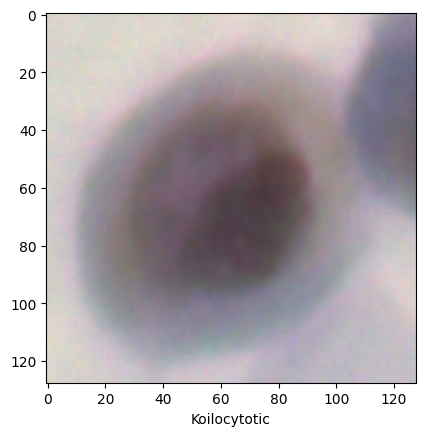

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=128)
features_densenet     = model_densenet.predict(data, batch_size=128)
features_efficientnet = model_densenet.predict(data, batch_size=128)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step
(4049, 4, 4, 2048)
(4049, 4, 4, 1024)
(4049, 4, 4, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 65537)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 1)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1
[0.15979608]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.3, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2834, 1)
(1215, 1)
(2834,)
(1215,)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,797 (7.02 KB)

 Trainable params: 1,797 (7.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 200
nn = model.fit(X_train, y_train, batch_size=128, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2762 - loss: 1.6315
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3544 - loss: 1.4115
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3766 - loss: 1.3972
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3885 - loss: 1.3866
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3629 - loss: 1.3845
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3656 - loss: 1.3886
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3773 - loss: 1.3779
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3891 - loss: 1.3454
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3794 - loss: 1.3603
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3831 - loss: 1.3571
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3777 - loss: 1.3463
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  43.62139917695473


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.52      0.73      0.60       242
         1.0       0.41      0.44      0.42       258
         2.0       0.44      0.61      0.51       205
         3.0       0.40      0.36      0.38       255
         4.0       0.30      0.09      0.14       255

    accuracy                           0.44      1215
   macro avg       0.41      0.45      0.41      1215
weighted avg       0.41      0.44      0.40      1215



[[176  45   0   1  20]
 [ 72 113  19  43  11]
 [  1  32 125  39   8]
 [ 18  20 109  93  15]
 [ 73  69  31  59  23]]


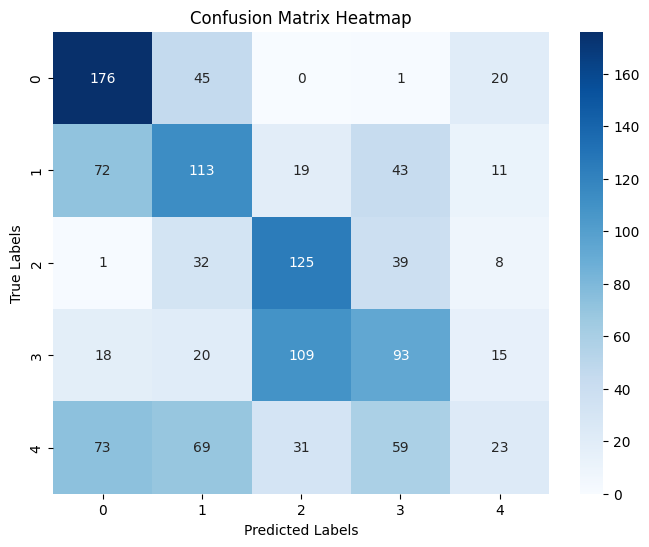

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Nucleus / Cytoplasm

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]
nc_ratio = []
area_nuc_ = []
area_cyt_ = []

height = 128
width = 128
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

def parse_dat_file(dat_path):
    points = []
    with open(dat_path, 'rb') as file:
        raw_data = file.read()
        decoded_data = raw_data.decode('utf-8', errors='ignore')
        lines = decoded_data.strip().split('\n')
        for line in lines:
            if ',' in line:
                try:
                    x_str, y_str = line.strip().split(',')
                    x, y = float(x_str), float(y_str)
                    points.append((x, y))
                except ValueError:
                    continue

    return points

    # if len(points) < 3:
    # raise ValueError("At least 3 points are required to form a polygon")

    # segmentation = [coord for point in points for coord in point]

# print(Class)
i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            file_path_cyt = f"{p}{a[:-4]}_cyt.dat"
            file_path_nuc = f"{p}{a[:-4]}_nuc.dat"
            points_nuc = parse_dat_file(file_path_nuc)
            points_cyt = parse_dat_file(file_path_cyt)
            # print(points_cyt)
            coords_cyt = np.array(points_cyt)
            x_cyt = coords_cyt[:, 0]
            y_cyt = coords_cyt[:, 1]
            area_cyt = 0.5 * np.abs(np.dot(x_cyt, np.roll(y_cyt, -1)) - np.dot(y_cyt, np.roll(x_cyt, -1)))
            coords_nuc = np.array(points_nuc)
            x_nuc = coords_nuc[:, 0]
            y_nuc = coords_nuc[:, 1]
            area_nuc = 0.5 * np.abs(np.dot(x_nuc, np.roll(y_nuc, -1)) - np.dot(y_nuc, np.roll(x_nuc, -1)))
            # print(area_nuc/area_cyt)
            nc_ratio.append(area_nuc/area_cyt)
            area_cyt_.append(area_cyt)
            area_nuc_.append(area_nuc)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
nc_ratio = np.array(nc_ratio)
area_cyt_ = np.array(area_cyt_)
area_nuc_ = np.array(area_nuc_)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]
nc_ratio = nc_ratio[s]
area_cyt_ = area_cyt_[s]
area_nuc_ = area_nuc_[s]

(4049, 128, 128, 3)
(4049,)
[0 0 0 ... 4 4 4]


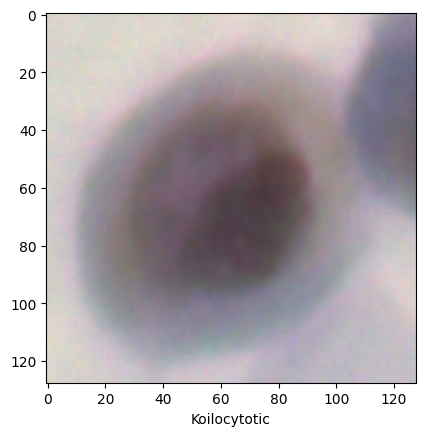

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=128)
features_densenet     = model_densenet.predict(data, batch_size=128)
features_efficientnet = model_densenet.predict(data, batch_size=128)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 276s 8s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 265s 8s/step
(4049, 4, 4, 2048)
(4049, 4, 4, 1024)
(4049, 4, 4, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label, area_cyt_, area_nuc_ in zip(features_resnet, features_densenet, features_efficientnet, labels, area_cyt_, area_nuc_):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    f_r = np.append(f_r, area_cyt_)
    f_r = np.append(f_r, area_nuc_)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 65539)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-3]
y = extracted_features[:, -3]
cyt_ = extracted_features[:, -2]
nuc_ = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 1)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)
principal_X_with_nc = np.concatenate((principal_X, cyt_.reshape(-1, 1), nuc_.reshape(-1, 1)), axis=1)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1
[0.15979608]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(
    principal_X_with_nc, y, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2834, 3)
(1215, 3)
(2834,)
(1215,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.02))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,309 (9.02 KB)

 Trainable params: 2,309 (9.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 200
nn = model.fit(X_train, y_train, batch_size=128, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2516 - loss: 796.6469
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3224 - loss: 259.0680
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3721 - loss: 180.9531
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3770 - loss: 186.7475
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4087 - loss: 173.4670
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3965 - loss: 166.4465
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4036 - loss: 170.6918
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4004 - loss: 153.4180
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4113 - loss: 143.6156
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4120 - loss: 135.5199
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4151 - loss: 134.4958
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  61.31687242798354


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       242
         1.0       0.60      0.36      0.45       258
         2.0       0.37      0.92      0.53       205
         3.0       0.52      0.17      0.26       255
         4.0       0.97      0.80      0.88       255

    accuracy                           0.61      1215
   macro avg       0.66      0.63      0.60      1215
weighted avg       0.67      0.61      0.60      1215



[[214  14  14   0   0]
 [ 30  93  97  38   0]
 [  0   7 189   3   6]
 [ 13  40 158  44   0]
 [  0   0  50   0 205]]


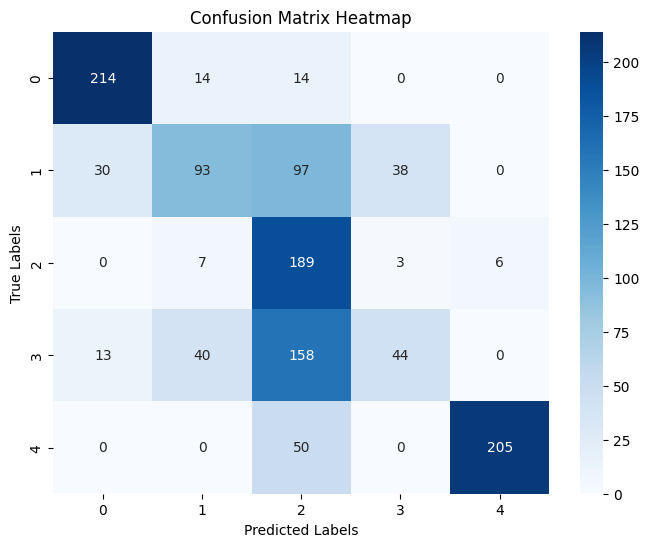

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# N/C ratio + N, C

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]
nc_ratio = []
area_nuc_ = []
area_cyt_ = []

height = 128
width = 128
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

def parse_dat_file(dat_path):
    points = []
    with open(dat_path, 'rb') as file:
        raw_data = file.read()
        decoded_data = raw_data.decode('utf-8', errors='ignore')
        lines = decoded_data.strip().split('\n')
        for line in lines:
            if ',' in line:
                try:
                    x_str, y_str = line.strip().split(',')
                    x, y = float(x_str), float(y_str)
                    points.append((x, y))
                except ValueError:
                    continue

    return points

    # if len(points) < 3:
    # raise ValueError("At least 3 points are required to form a polygon")

    # segmentation = [coord for point in points for coord in point]

# print(Class)
i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            file_path_cyt = f"{p}{a[:-4]}_cyt.dat"
            file_path_nuc = f"{p}{a[:-4]}_nuc.dat"
            points_nuc = parse_dat_file(file_path_nuc)
            points_cyt = parse_dat_file(file_path_cyt)
            # print(points_cyt)
            coords_cyt = np.array(points_cyt)
            x_cyt = coords_cyt[:, 0]
            y_cyt = coords_cyt[:, 1]
            area_cyt = 0.5 * np.abs(np.dot(x_cyt, np.roll(y_cyt, -1)) - np.dot(y_cyt, np.roll(x_cyt, -1)))
            coords_nuc = np.array(points_nuc)
            x_nuc = coords_nuc[:, 0]
            y_nuc = coords_nuc[:, 1]
            area_nuc = 0.5 * np.abs(np.dot(x_nuc, np.roll(y_nuc, -1)) - np.dot(y_nuc, np.roll(x_nuc, -1)))
            # print(area_nuc/area_cyt)
            nc_ratio.append(area_nuc/area_cyt)
            area_cyt_.append(area_cyt)
            area_nuc_.append(area_nuc)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
nc_ratio = np.array(nc_ratio)
area_cyt_ = np.array(area_cyt_)
area_nuc_ = np.array(area_nuc_)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]
nc_ratio = nc_ratio[s]
area_cyt_ = area_cyt_[s]
area_nuc_ = area_nuc_[s]

(4049, 128, 128, 3)
(4049,)
[0 0 0 ... 4 4 4]


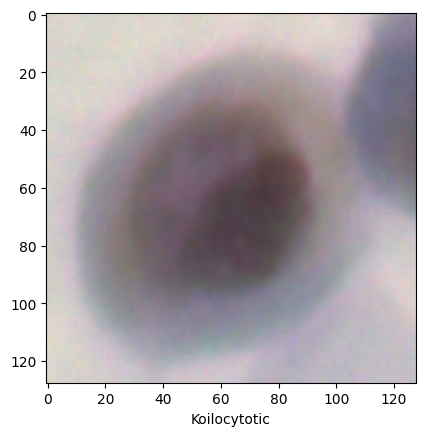

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=128)
features_densenet     = model_densenet.predict(data, batch_size=128)
features_efficientnet = model_densenet.predict(data, batch_size=128)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 291s 9s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 272s 8s/step
(4049, 4, 4, 2048)
(4049, 4, 4, 1024)
(4049, 4, 4, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label, area_cyt_, area_nuc_, nc_ratio in zip(features_resnet, features_densenet, features_efficientnet, labels, area_cyt_, area_nuc_, nc_ratio):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    f_r = np.append(f_r, area_cyt_)
    f_r = np.append(f_r, area_nuc_)
    f_r = np.append(f_r, nc_ratio)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 65540)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-4]
y = extracted_features[:, -4]
cyt_ = extracted_features[:, -3]
nuc_ = extracted_features[:, -2]
nc = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 1)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)
principal_X_with_nc = np.concatenate((principal_X, cyt_.reshape(-1, 1), nuc_.reshape(-1, 1), nc.reshape(-1, 1)), axis=1)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1
[0.15979608]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(
    principal_X_with_nc, y, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2834, 4)
(1215, 4)
(2834,)
(1215,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.02))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,565 (10.02 KB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 200
nn = model.fit(X_train, y_train, batch_size=128, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2105 - loss: 1686.5778
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2994 - loss: 293.2598
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3697 - loss: 200.4094
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3708 - loss: 189.3222
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3819 - loss: 184.5852
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4036 - loss: 158.3878
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3800 - loss: 172.2134
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4075 - loss: 155.2320
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4131 - loss: 154.8802
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3966 - loss: 152.3210
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4280 - loss: 151.8106
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  64.77366255144032


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       242
         1.0       0.47      0.52      0.49       258
         2.0       0.45      0.61      0.52       205
         3.0       0.56      0.44      0.50       255
         4.0       0.97      0.83      0.89       255

    accuracy                           0.65      1215
   macro avg       0.66      0.65      0.65      1215
weighted avg       0.67      0.65      0.65      1215



[[204  28   7   2   1]
 [ 22 133  46  57   0]
 [  0  45 126  29   5]
 [ 11  76  55 113   0]
 [  1   0  43   0 211]]


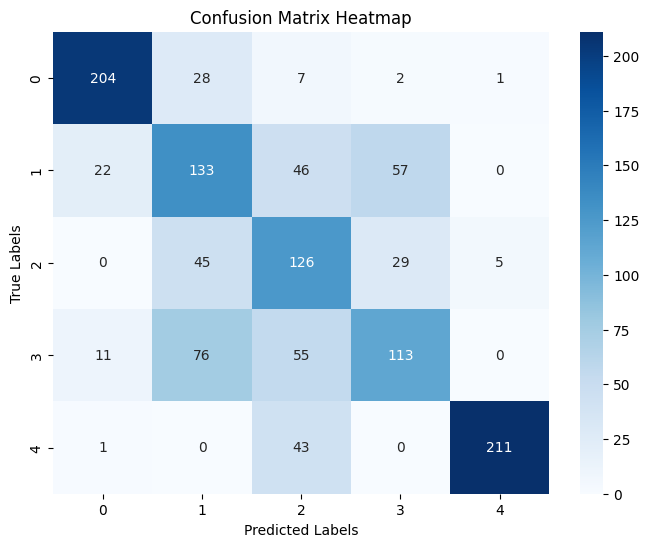

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Add N/C ratio (OLD)

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]
nc_ratio = []

height = 64
width = 64
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

def parse_dat_file(dat_path):
    points = []
    with open(dat_path, 'rb') as file:
        raw_data = file.read()
        decoded_data = raw_data.decode('utf-8', errors='ignore')
        lines = decoded_data.strip().split('\n')
        for line in lines:
            if ',' in line:
                try:
                    x_str, y_str = line.strip().split(',')
                    x, y = float(x_str), float(y_str)
                    points.append((x, y))
                except ValueError:
                    continue

    return points

    # if len(points) < 3:
    # raise ValueError("At least 3 points are required to form a polygon")

    # segmentation = [coord for point in points for coord in point]

# print(Class)
i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            file_path_cyt = f"{p}{a[:-4]}_cyt.dat"
            file_path_nuc = f"{p}{a[:-4]}_nuc.dat"
            points_nuc = parse_dat_file(file_path_nuc)
            points_cyt = parse_dat_file(file_path_cyt)
            # print(points_cyt)
            coords_cyt = np.array(points_cyt)
            x_cyt = coords_cyt[:, 0]
            y_cyt = coords_cyt[:, 1]
            area_cyt = 0.5 * np.abs(np.dot(x_cyt, np.roll(y_cyt, -1)) - np.dot(y_cyt, np.roll(x_cyt, -1)))
            coords_nuc = np.array(points_nuc)
            x_nuc = coords_nuc[:, 0]
            y_nuc = coords_nuc[:, 1]
            area_nuc = 0.5 * np.abs(np.dot(x_nuc, np.roll(y_nuc, -1)) - np.dot(y_nuc, np.roll(x_nuc, -1)))
            # print(area_nuc/area_cyt)
            nc_ratio.append(area_nuc/area_cyt)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
nc_ratio = np.array(nc_ratio)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]
nc_ratio = nc_ratio[s]

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


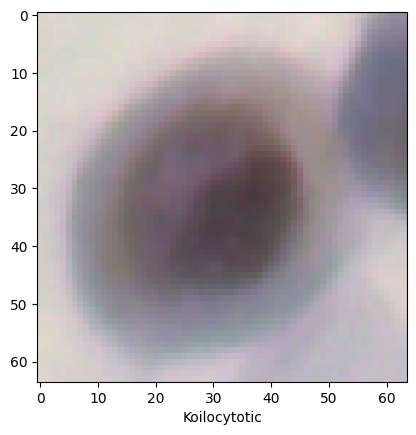

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=32)
features_densenet     = model_densenet.predict(data, batch_size=32)
features_efficientnet = model_densenet.predict(data, batch_size=32)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step
(4049, 2, 2, 2048)
(4049, 2, 2, 1024)
(4049, 2, 2, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label, nc_ratio in zip(features_resnet, features_densenet, features_efficientnet, labels, nc_ratio):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    f_r = np.append(f_r, nc_ratio)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 16386)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-2]
y = extracted_features[:, -2]
nc = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)
principal_X_with_nc = np.concatenate((principal_X, nc.reshape(-1, 1), ), axis=1)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1376
[1.58362208e-01 9.56092704e-02 4.11948237e-02 ... 5.54878919e-05
 5.54254230e-05 5.53718591e-05]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(
    principal_X_with_nc, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3239, 1377)
(810, 1377)
(3239,)
(810,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 1377)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       352,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,053 (1.35 MB)

 Trainable params: 354,053 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100
nn = model.fit(X_train, y_train, batch_size=32, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6328 - loss: 1.0110
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.1822
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9834 - loss: 0.0828
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0452
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9959 - loss: 0.0299
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0170
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.0141
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0081
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0062
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  94.44444444444444


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       167
         1.0       0.93      0.87      0.90       165
         2.0       0.88      0.93      0.91       132
         3.0       0.99      0.97      0.98       174
         4.0       0.95      0.97      0.96       172

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



[[164   3   0   0   0]
 [  6 143  11   0   5]
 [  0   7 123   0   2]
 [  1   0   2 169   2]
 [  1   1   3   1 166]]


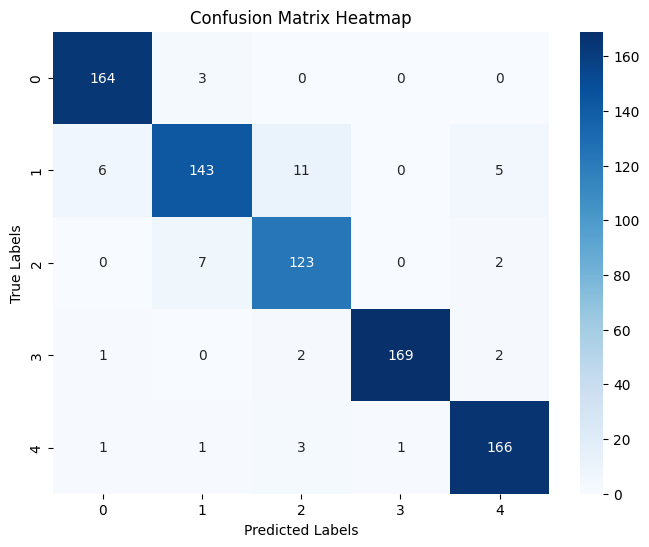

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# (OLD)

In [ ]:
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]
nc_ratio = []

height = 64
width = 64
channels = 3
# classes = 43
n_inputs = height * width * channels

path1 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/drive/MyDrive/Cancer cells/Datasets/Kaggle_cirvical/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

def parse_dat_file(dat_path):
    points = []
    with open(dat_path, 'rb') as file:
        raw_data = file.read()
        decoded_data = raw_data.decode('utf-8', errors='ignore')
        lines = decoded_data.strip().split('\n')
        for line in lines:
            if ',' in line:
                try:
                    x_str, y_str = line.strip().split(',')
                    x, y = float(x_str), float(y_str)
                    points.append((x, y))
                except ValueError:
                    continue

    return points

    # if len(points) < 3:
    # raise ValueError("At least 3 points are required to form a polygon")

    # segmentation = [coord for point in points for coord in point]

# print(Class)
i = 0
for p in path:
    # print(p)
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            file_path_cyt = f"{p}{a[:-4]}_cyt.dat"
            file_path_nuc = f"{p}{a[:-4]}_nuc.dat"
            points_nuc = parse_dat_file(file_path_nuc)
            points_cyt = parse_dat_file(file_path_cyt)
            # print(points_cyt)
            coords_cyt = np.array(points_cyt)
            x_cyt = coords_cyt[:, 0]
            y_cyt = coords_cyt[:, 1]
            area_cyt = 0.5 * np.abs(np.dot(x_cyt, np.roll(y_cyt, -1)) - np.dot(y_cyt, np.roll(x_cyt, -1)))
            coords_nuc = np.array(points_nuc)
            x_nuc = coords_nuc[:, 0]
            y_nuc = coords_nuc[:, 1]
            area_nuc = 0.5 * np.abs(np.dot(x_nuc, np.roll(y_nuc, -1)) - np.dot(y_nuc, np.roll(x_nuc, -1)))
            # print(area_nuc/area_cyt)
            nc_ratio.append(area_nuc/area_cyt)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
nc_ratio = np.array(nc_ratio)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]
nc_ratio = nc_ratio[s]

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


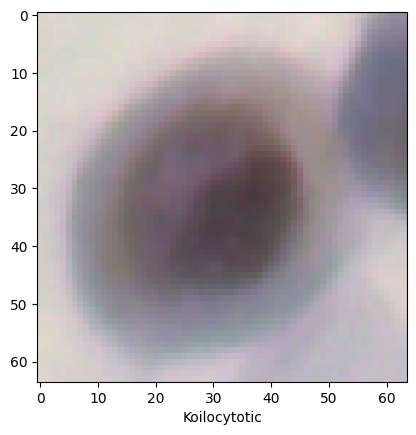

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=32)
features_densenet     = model_densenet.predict(data, batch_size=32)
features_efficientnet = model_densenet.predict(data, batch_size=32)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step
(4049, 2, 2, 2048)
(4049, 2, 2, 1024)
(4049, 2, 2, 1024)


In [ ]:
extracted_features = []

for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    # f_r = np.append(f_r, nc_ratio)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 16385)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]
# nc = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)
# principal_X_with_nc = np.concatenate((principal_X, ), axis=1)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))
# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

1376
[1.58362208e-01 9.56092704e-02 4.11948237e-02 ... 5.54878919e-05
 5.54254230e-05 5.53718591e-05]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(
    principal_X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3239, 1376)
(810, 1376)
(3239,)
(810,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       352,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,797 (1.35 MB)

 Trainable params: 353,797 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
nn = model.fit(X_train, y_train, batch_size=32, epochs=epochs)
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6383 - loss: 0.9953
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9620 - loss: 0.1888
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9861 - loss: 0.0828
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9936 - loss: 0.0512
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9959 - loss: 0.0314
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0174
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0111
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0104
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 0.0085
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0066
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

Accuracy is:  95.43209876543209


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       167
         1.0       0.94      0.88      0.91       165
         2.0       0.91      0.94      0.93       132
         3.0       0.99      0.98      0.99       174
         4.0       0.97      0.97      0.97       172

    accuracy                           0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.95       810



[[165   2   0   0   0]
 [  5 146   9   1   4]
 [  1   6 124   0   1]
 [  1   0   1 171   1]
 [  1   2   2   0 167]]


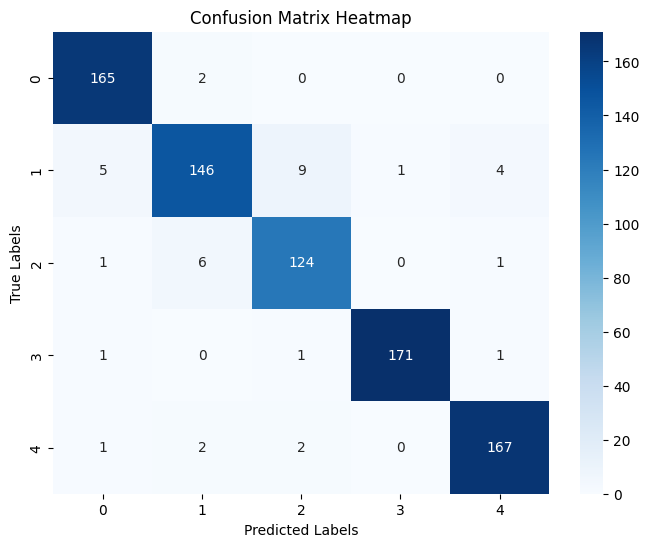

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(y_test, y_nn)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()